<a href="https://colab.research.google.com/github/eyaler/face_toolbox_keras/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
!git clone https://github.com/eyaler/face_toolbox_keras.git
%cd face_toolbox_keras

/content
fatal: destination path 'face_toolbox_keras' already exists and is not an empty directory.
/content/face_toolbox_keras


In [2]:
!gdown https://drive.google.com/uc?id=1H37LER8mRRI4q_nxpS3uQz3DcGHkTrNU
!mv lresnet100e_ir_keras.h5 ./models/verifier/insightface/lresnet100e_ir_keras.h5
!gdown https://drive.google.com/uc?id=18MyyXQIwhR5I6gzipYMiJ9ywgvFWQMvI
!mv backbone_ir50_ms1m_keras.h5 ./models/verifier/face_evoLVe_ir50/backbone_ir50_ms1m_keras.h5
!gdown https://drive.google.com/uc?id=1P_eQHU8bNJEsB6hHt_fnltOwQVKIfhiX
!mv backbone_ir50_asia_keras.h5 ./models/verifier/face_evoLVe_ir50/backbone_ir50_asia_keras.h5

Downloading...
From: https://drive.google.com/uc?id=1H37LER8mRRI4q_nxpS3uQz3DcGHkTrNU
To: /content/face_toolbox_keras/lresnet100e_ir_keras.h5
100% 262M/262M [00:01<00:00, 214MB/s]
Downloading...
From: https://drive.google.com/uc?id=18MyyXQIwhR5I6gzipYMiJ9ywgvFWQMvI
To: /content/face_toolbox_keras/backbone_ir50_ms1m_keras.h5
100% 175M/175M [00:01<00:00, 90.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P_eQHU8bNJEsB6hHt_fnltOwQVKIfhiX
To: /content/face_toolbox_keras/backbone_ir50_asia_keras.h5
100% 175M/175M [00:01<00:00, 106MB/s]


In [3]:
!pip install keras==2.2.4
%tensorflow_version 1.x
!pip install h5py==2.10.0

TensorFlow 1.x selected.


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

---

In [6]:
def resize_image(im, max_size=768):
    if np.max(im.shape) > max_size:
        ratio = max_size / np.max(im.shape)
        print(f"Resize image to ({str(int(im.shape[1]*ratio))}, {str(int(im.shape[0]*ratio))}).")
        return cv2.resize(im, (0,0), fx=ratio, fy=ratio)
    return im

Resize image to (768, 576).


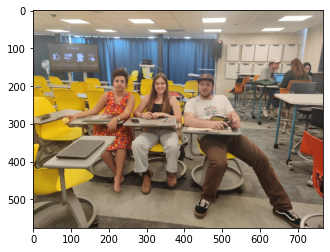

In [7]:
# Test images are obtained on https://www.pexels.com/
im = cv2.imread("images/test.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

---
# 0. Coordinate ordering

The coordinate in this demo has ordering `(x, y)`, which follows the format fo numpy array: `x` is the vertical axis and `y` the horizontal axis.

---
# 1. Face detection

Face deteciton using S3FD and FAN.

In [8]:
from models.detector import face_detector

Using TensorFlow backend.


In [9]:
fd = face_detector.FaceAlignmentDetector(
    lmd_weights_path="./models/detector/FAN/2DFAN-4_keras.h5"# 2DFAN-4_keras.h5, 2DFAN-1_keras.h5
)

## Detect faces

In [10]:
bboxes = fd.detect_face(im, with_landmarks=False)

In [23]:
assert len(bboxes) > 0, "No face detected."

# Display detected face
x0, y0, x1, y1, score = bboxes[0] # show the first detected face
x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])

plt.imshow(im[x0:x1, y0:y1, :])

found 5 faces


AttributeError: ignored

<Figure size 432x288 with 0 Axes>

## Detect faces and landmarks

`FaceDetector` will instantiate `FANLandmarksDetector` when calling `detect_face(with_landmarks=True)` the first time.

In [12]:
bboxes, landmarks = fd.detect_face(im, with_landmarks=True)

Building FAN for landmarks detection...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Done.


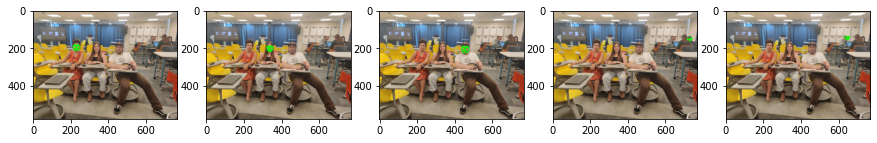

In [13]:
# Display landmarks
plt.figure(figsize=(15,8))
num_faces = len(bboxes)
for i in range(num_faces):
    try:
        plt.subplot(1, num_faces, i+1)
        plt.imshow(fd.draw_landmarks(im, landmarks[i], color=(0,255,0)))
    except:
        pass

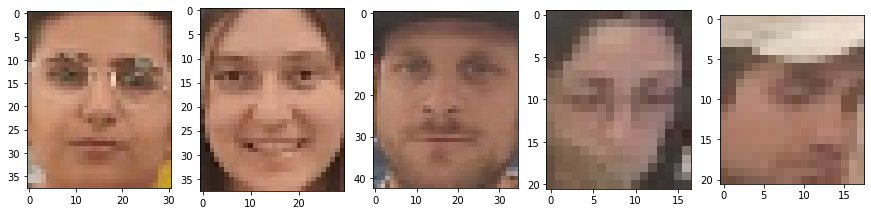

In [25]:
plt.figure(figsize=(15,8))
num_faces = len(bboxes)
for i in range(num_faces):
    try:
        plt.subplot(1, num_faces, i+1)
        x0, y0, x1, y1, score = bboxes[i] 
        x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])
        
        plt.imshow(im[x0:x1, y0:y1, :])
        plt.imsave(f'{i}.jpg')
    except:
        pass

---
# 2. Face parsing

Face parsing using BiSeNet.

In [14]:
from models.parser import face_parser

In [15]:
prs = face_parser.FaceParser()

## Parse without deteciton

In [16]:
out = prs.parse_face(im)

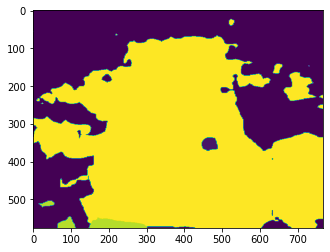

In [17]:
plt.imshow(out[0])

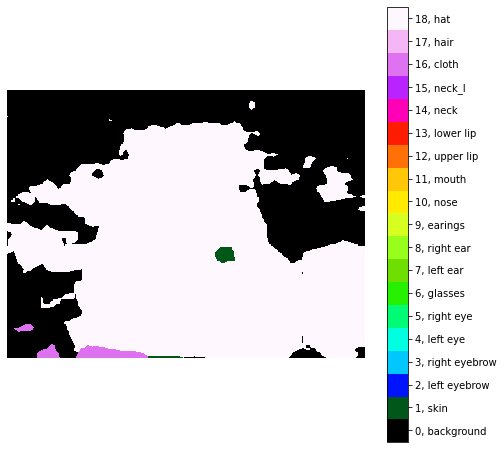

In [18]:
# Show parsing result with annotations

from utils.visualize import show_parsing_with_annos
show_parsing_with_annos(out[0])

## Parse with detection

Parsing network has its best performance on single face (even better if aligned).

In [19]:
im = cv2.imread("images/test2.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

TypeError: ignored

In [ ]:
# Set detector into FaceParser
try:
    fd
except:
    from detector import face_detector
    fd = face_detector.FaceAlignmentDetector()
    
prs.set_detector(fd)
# prs.remove_detector()

In [ ]:
out = prs.parse_face(im, with_detection=True)

In [ ]:
#plt.figure(figsize=(15,8))
num_faces = len(out)
for i in range(num_faces):
    try:
        plt.subplot(1, num_faces, i+1)
        plt.imshow(out[i])
    except:
        pass

---
# 3. Detect irises

Iris detection using ELG (Eye region Landmarks based Gaze estimation).

In [ ]:
from models.detector.iris_detector import IrisDetector

## Detect iris, eyelibs and pulpils

In [ ]:
im = cv2.imread("images/test5.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [ ]:
idet = IrisDetector()

In [ ]:
idet.set_detector(fd)

In [ ]:
eye_lms = idet.detect_iris(im)

In [ ]:
# Display detection result
plt.figure(figsize=(15,10))
draw = idet.draw_pupil(im, eye_lms[0][0,...]) # draw left eye
draw = idet.draw_pupil(draw, eye_lms[0][1,...]) # draw right eye
bboxes = fd.detect_face(im, with_landmarks=False)
x0, y0, x1, y1, _ = bboxes[0].astype(np.int32)
plt.subplot(1,2,1)
plt.imshow(draw)
plt.subplot(1,2,2)
plt.imshow(draw[x0:x1, y0:y1])

---
# 4. Face verification

Face verification using facenet.

In [ ]:
from models.verifier.face_verifier import FaceVerifier

In [ ]:
im1 = cv2.imread("images/test0.jpg")[..., ::-1]
im1 = resize_image(im1) # Resize image to prevent GPU OOM.
im2 = cv2.imread("images/BO1.jpg")[..., ::-1]
im2 = resize_image(im2) # Resize image to prevent GPU OOM.
im3 = cv2.imread("images/DT.jpg")[..., ::-1]
im3 = resize_image(im3) # Resize image to prevent GPU OOM.

In [ ]:
fv = FaceVerifier(classes=512, extractor="facenet") # extractor="insightface"

In [ ]:
fv.set_detector(fd)

## Verify if two given faces are the same person

In [ ]:
# Face verification
result1, distance1 = fv.verify(im1, im2, threshold=0.5, with_detection=True, with_alignment=False, return_distance=True)
result2, distance2 = fv.verify(im1, im3, threshold=0.5, with_detection=True, with_alignment=False, return_distance=True)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.title(f"Source face")
plt.imshow(im1)
plt.subplot(1,3,2)
plt.title(f"Same person: {str(result1)}\n Cosine distance: {str(round(distance1, 2))}")
plt.imshow(im2)
plt.subplot(1,3,3)
plt.title(f"Same person: {str(result2)}\n Cosine distance: {str(round(distance2, 2))}")
plt.imshow(im3)

---
# 5. Gender and Age Estimation

Gender/Age estimation using insightface mobilenet.

In [ ]:
from models.estimator.gender_age_estimator import GenderAgeEstimator

In [ ]:
im = cv2.imread("images/BO1.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [ ]:
gae = GenderAgeEstimator(model_type="insightface")

In [ ]:
gae.set_detector(fd)

In [ ]:
gender, age = gae.predict_gender_age(im, with_detection=True)

In [ ]:
print("Gender: female") if gender == 0 else print("Gender: male")
print(f"Age: {str(age)}")